In [48]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as skl

In [51]:
grd = r'https://github.com/gmarinr/TOPD/raw/refs/heads/main/Archivos/grd_2023_saved.parquet'
hospital = r'https://github.com/gmarinr/TOPD/raw/refs/heads/main/Archivos/hospital.parquet'
ir_grd = r'https://github.com/gmarinr/TOPD/raw/refs/heads/main/Archivos/ir-grd.parquet'
cie = r'https://github.com/gmarinr/TOPD/raw/refs/heads/main/Archivos/CIE-10%20(2).xlsx'

## Obtener DataFrame
1.- Realizamos los tratamientos necesarios para la hacer el merge con los datos.  
2.- A partir de crear el DataFrame Principal revisamos los datos que tenemos y vemos los nulos.

In [53]:
df_grd = pd.read_parquet(grd)
df_hospital = pd.read_parquet(hospital)
df_ir_grd = pd.read_parquet(ir_grd)
df_cie = pd.read_excel(cie, engine='openpyxl')
# hospital, ir_grd no tienen header
df_ir_grd.columns = ['IR_29301_COD_GRD', 'DESCCRIPCION_GRD']
df_hospital.columns = ['COD_HOSPITAL', 'HOSPITAL']

# Limpiar nombres de columnas antes
for df in [df_grd, df_hospital, df_ir_grd, df_cie]:
    df.columns = df.columns.str.strip()

# Hacer los merges
df_grd = df_grd.merge(df_hospital, on='COD_HOSPITAL', how='left')
df_grd = df_grd.merge(df_ir_grd, on='IR_29301_COD_GRD', how='left')
df_grd = df_grd.merge(df_cie, left_on='DIAGNOSTICO1', right_on='Código', how='left')

# Luego eliminas columnas de unión
df_grd = df_grd.drop(columns=['COD_HOSPITAL', 'IR_29301_COD_GRD', 'DIAGNOSTICO1', 'Código'])
df_grd.head(2)

,CIP_ENCRIPTADO,SEXO,FECHA_NACIMIENTO,SERVICIO_SALUD,TIPO_INGRESO,FECHA_INGRESO,FECHAALTA,TIPOALTA,IR_29301_PESO,IR_29301_SEVERIDAD,IR_29301_MORTALIDAD,EDAD,DIAS_ESTANCIA,HOSPITAL,DESCCRIPCION_GRD,Versión,Descripción,Categoría,Sección,Capítulo
0,72196813.0,HOMBRE,1980-04-13,VALDIVIA,URGENCIA,2023-03-12,2023-03-14,DOMICILIO,0.7094,1.0,1.0,43.0,2,Hospital Clínico Regional (Valdivia),MH INFECCIONES GASTROINTESTINALES MAYORES,CIE-v2013,Apendicitis aguda con peritonitis localizada,K35 APENDICITIS AGUDA,K35-K38 ENFERMEDADES DEL APÉNDICE,Cap.11 ENFERMEDADES DEL APARATO DIGESTIVO (K0...
1,NaN,HOMBRE,2001-11-04,METROPOLITANO SURORIENTE,URGENCIA,2023-11-04,2023-11-10,DOMICILIO,1.0869,1.0,1.0,22.0,6,Complejo Hospitalario Dr. Sótero del Río (San...,PH PROCEDIMIENTOS MODERADAMENTE COMPLEJOS SOB...,CIE-v2013,Otros tipos de neumotórax espontáneo,J93 NEUMOTÓRAX,J90-J94 OTRAS ENFERMEDADES DE LA PLEURA,Cap.10 ENFERMEDADES DEL APARATO RESPIRATORIO ...


In [ ]:
df_grd['CIP_ENCRIPTADO'].isna().mean() #0.0015727399438430838 de valores nulos.

# Eliminar columnas que no se usan, dado ser un valor mínimo e irrelevante, dado que no podemos trazar a estas personas.
df_grd['CIP_ENCRIPTADO'].dropna(inplace=True);

In [ ]:
df_grd['CIP_ENCRIPTADO'].duplicated().mean()*100
# 21.13% de valores duplicados, por lo cual tenemos buena muestra para ver los reingresos.

np.float64(21.130602825929913)

In [ ]:
# Asegura el tipo datetime
df_grd['FECHA_INGRESO'] = pd.to_datetime(df_grd['FECHA_INGRESO'])
df_grd['FECHAALTA']     = pd.to_datetime(df_grd['FECHAALTA'])

# Ordena episodios dentro de cada paciente
df_sorted = (
    df_grd
      .sort_values(['CIP_ENCRIPTADO', 'FECHA_INGRESO'])
      .reset_index(drop=True)
)
# Fecha del próximo ingreso
df_sorted['NEXT_FECHA_INGRESO'] = (
    df_sorted
      .groupby('CIP_ENCRIPTADO')['FECHA_INGRESO']
      .shift(-1)                       # episodio siguiente
)

# Diferencia en días (sólo si hay próximo episodio)
df_sorted['DIAS_REINGRESO'] = (
    (df_sorted['NEXT_FECHA_INGRESO'] - df_sorted['FECHAALTA'])
      .dt.days
)

mask_gap_ok = df_sorted['DIAS_REINGRESO'] >= 0
df_gaps     = df_sorted[mask_gap_ok].copy()

n_total_ep      = len(df_sorted)                    # todos los episodios
n_con_gap       = len(df_gaps)                      # episodios con reingreso calculable
pct_ep_con_gap  = n_con_gap / n_total_ep * 100

n_pac_total     = df_sorted['CIP_ENCRIPTADO'].nunique()
n_pac_multiep   = df_sorted.loc[mask_gap_ok, 'CIP_ENCRIPTADO'].nunique()
pct_pac_multiep = n_pac_multiep / n_pac_total * 100

n_total_ep, n_con_gap, pct_ep_con_gap, n_pac_total, n_pac_multiep, pct_pac_multiep


(1039587, 214693, 20.651758823455854, 819915, 149882, 18.28018758041992)

In [ ]:
# --- parámetros ---
WINDOWS = [7, 30, 60, 90]       # Ventanas a analizar

# --- función auxiliar: True si reingresa en ≤ w días ---
def etiqueta_reingreso_episodio(df, w):
    # 1) Si DIAS_REINGRESO es NaN  -> no se observó reingreso (False)
    # 2) Si gap >= 0 y <= w        -> True
    return (df['DIAS_REINGRESO'] <= w).fillna(False)

# --- crear etiquetas ---
for w in WINDOWS:
    df_sorted[f'READM_{w}D'] = etiqueta_reingreso_episodio(df_sorted, w).astype(int)
df_util = df_sorted[df_sorted['DIAS_REINGRESO']  > 0].copy() # sólo episodios con reingreso positivo


In [ ]:
df_util['DIAS_REINGRESO'].describe()

count    200236.000000
mean         59.932205
std          66.778633
min           1.000000
25%          12.000000
50%          33.000000
75%          86.000000
max         360.000000
Name: DIAS_REINGRESO, dtype: float64

In [ ]:
# --- graficar histogramas ---
import plotly.express as px
fig = px.histogram(df_util, x="DIAS_REINGRESO", nbins=75)
fig.update_traces(marker=dict(line=dict(width=1, color='black')))

fig.show()

Podemos ver una posible tendencia exponencial en la fecha de reingresos.  
Seguiremos explorando si existe alguna relación con el tipo de motivo de reingreso.  

In [ ]:
# === 1.a  Opción A: usar TIPO_INGRESO (pocas categorías) ============
df_plot = df_sorted[['TIPO_INGRESO', 'DIAS_REINGRESO']].copy()

# === 1.b  Opción B: usar diagnóstico ================================
#  Usamos CAPÍTULO (nivel alto) para no tener cientos de códigos
df_plot = df_sorted[['Capítulo', 'DIAS_REINGRESO']].rename(columns={'Capítulo':'MOTIVO'})
df_plot['MOTIVO'] = df_plot['MOTIVO'].fillna('SIN_INF')


def correlation_ratio(categories, values):
    """
    η (eta) para numérico vs. categórico.
    0 = sin asociación, 1 = perfecta.
    """
    cat_groups = {}
    for cat, val in zip(categories, values):
        cat_groups.setdefault(cat, []).append(val)
    # media global
    grand_mean = np.nanmean(values)
    # Suma de cuadrados inter-grupos y total
    ss_between = sum(len(v)*((np.nanmean(v)-grand_mean)**2) for v in cat_groups.values())
    ss_total   = np.nansum((values - grand_mean)**2)
    return np.sqrt(ss_between / ss_total)

eta = correlation_ratio(df_plot.iloc[:,0], df_plot['DIAS_REINGRESO'])
print(f"η num‑cat = {eta:0.3f}")


η num‑cat = 0.304


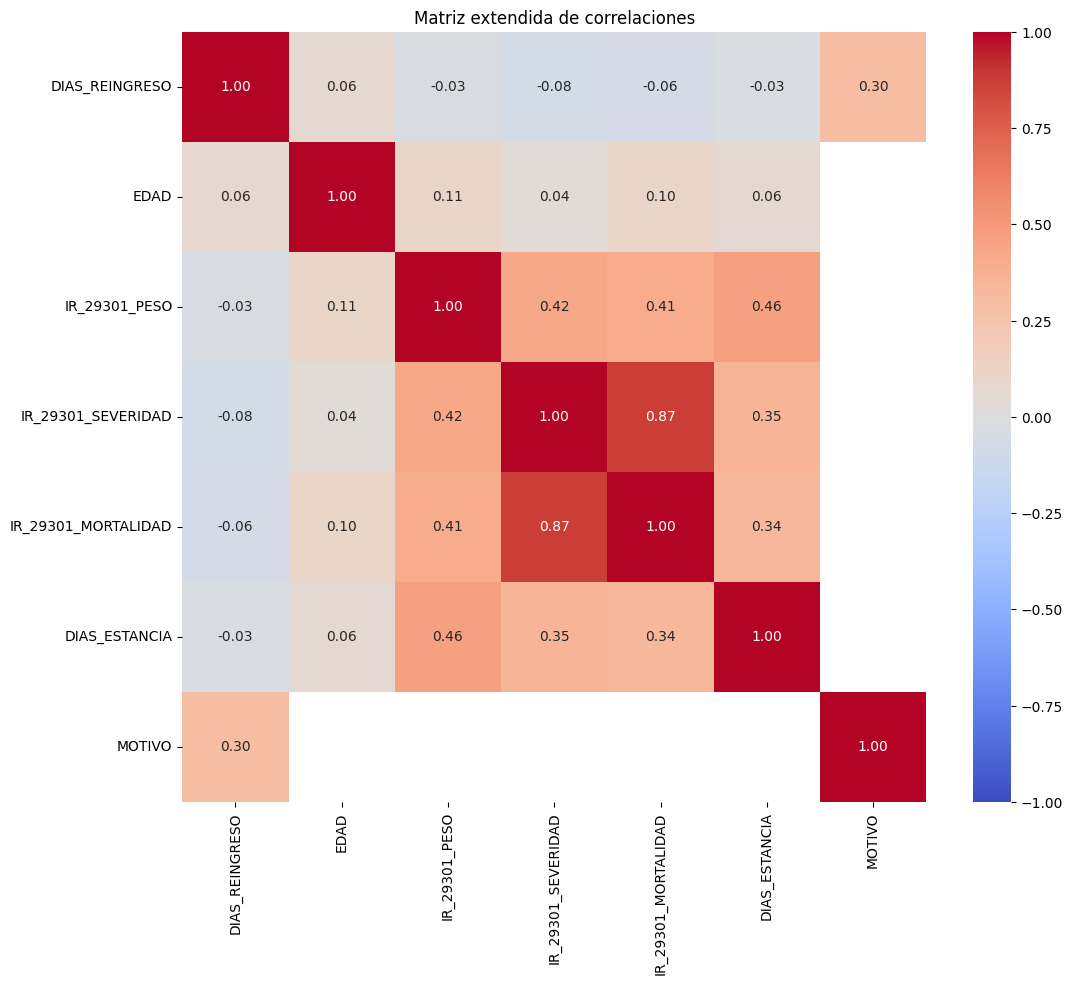

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# 1) Correlaciones numéricas estándar
num_cols = ['DIAS_REINGRESO', 'EDAD', 'IR_29301_PESO',
            'IR_29301_SEVERIDAD', 'IR_29301_MORTALIDAD', 'DIAS_ESTANCIA']
corr_num = df_sorted[num_cols].corr()

# 2) Añade nueva fila/columna con η
corr_matrix = corr_num.copy()
corr_matrix.loc['DIAS_REINGRESO', 'MOTIVO'] = eta
corr_matrix.loc['MOTIVO', 'DIAS_REINGRESO'] = eta
corr_matrix.loc['MOTIVO', 'MOTIVO'] = 1        # Autocorrelación

plt.figure(figsize=(12,10))
sns.heatmap(corr_matrix, annot=True, vmin=-1, vmax=1,
            cmap='coolwarm', fmt='.2f', mask=corr_matrix.isna())
plt.title('Matriz extendida de correlaciones')
plt.show()


No se ve una correlación clara entre el motivo de reingreso y la fecha de reingreso. ni con el resto de posibles variables.  

In [ ]:
media_cat = (
    df_plot
      .groupby(df_plot.columns[0])['DIAS_REINGRESO']
      .mean()
      .sort_values(ascending=False)
      .reset_index()
)

fig = px.bar(media_cat, x=df_plot.columns[0], y='DIAS_REINGRESO',
             title='Días medios hasta reingreso por motivo', text_auto='.1f')
fig.update_layout(xaxis_title='Motivo de ingreso', yaxis_title='Días hasta reingreso')
fig.show()


Vemos el gráfico de las ventanas de reingreso.

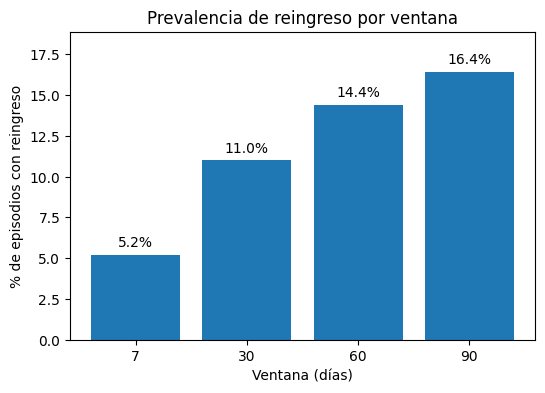

In [ ]:
prev_ep  = [df_sorted[f'READM_{w}D'].mean()*100 for w in WINDOWS]

plt.figure(figsize=(6,4))
plt.bar([str(w) for w in WINDOWS], prev_ep)
plt.ylabel('% de episodios con reingreso')
plt.xlabel('Ventana (días)')
plt.title('Prevalencia de reingreso por ventana')
for x, y in zip(WINDOWS, prev_ep):
    plt.text(str(x), y+0.5, f'{y:0.1f}%', ha='center')
plt.ylim(0, max(prev_ep)*1.15)
plt.show()

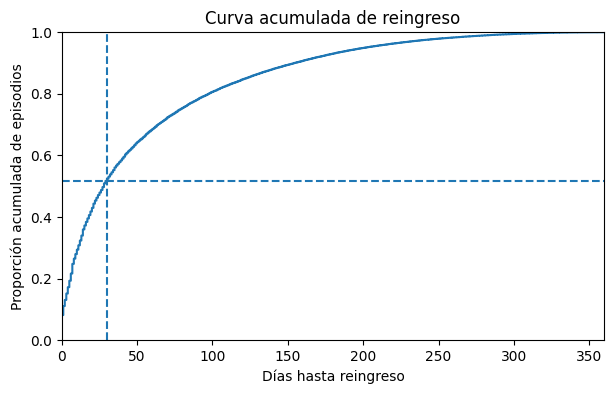

In [ ]:
dias_vals = df_sorted['DIAS_REINGRESO'].dropna().values
dias_sorted = np.sort(dias_vals)

# proporción acumulada
cum_prop = np.arange(1, len(dias_sorted)+1) / len(dias_sorted)

plt.figure(figsize=(7,4))
plt.step(dias_sorted, cum_prop, where='post')
plt.axvline(30, linestyle='--')   # ejemplo de ventana
plt.axhline(cum_prop[dias_sorted.searchsorted(30)], linestyle='--')
plt.xlabel('Días hasta reingreso')
plt.ylabel('Proporción acumulada de episodios')
plt.title('Curva acumulada de reingreso')
plt.ylim(0,1)
plt.xlim(0, dias_sorted.max())
plt.show()